ライブラリ読み込み

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
import numpy as np
import itertools
from sklearn import preprocessing
import pandas as pd
%matplotlib inline
import matplotlib
import ipywidgets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTENC
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import sklearn.metrics as mtr
import shap

基本データ読み込み

In [ ]:
raw_data=pd.read_csv('../data/data.csv',index_col=0)
x=raw_data.drop('Rupture',axis=1)
y=raw_data['Rupture']

基本データの処理

In [15]:
#使わない特徴量を削除
drop_li=['FirstDiagnosis', 'InitialConsultation', 'LastConsulation','DateofRupture', 'Birthday', 'AgeatIniCon','Days','SAH','PolycysticKindney']
x=x.drop(drop_li,axis=1)


#特徴量名変更
columns=x.columns
columns=[(c if c!='AgeatRuporLasCon' else 'Age') for c in columns]
x.columns=columns


#タバコ歴をカテゴリー化
dummy_col=['Smoke']
for c in dummy_col:
    x[c]=x[c].astype('category')
    
    
#血行力学データの統計量を一部拡張
x['PLcver2R']=(x['TMAXPLcver2']/x['TMINPLcver2']).replace([np.inf, -np.inf], np.nan).fillna(0)
x['PLcOldver2R']=(x['TMAXPLcOldver2']/x['TMINPLcOldver2']).replace([np.inf, -np.inf], np.nan).fillna(0)
x['ELR']=(x['TMAXEL']/x['TMINEL']).replace([np.inf, -np.inf], np.nan).fillna(0)
x['ELVR']=(x['TMAXELV']/x['TMINELV']).replace([np.inf, -np.inf], np.nan).fillna(0)

x['SCIR']=(x['TMAXSCI']/x['TMINSCI']).replace([np.inf, -np.inf], np.nan).fillna(0)
x['LSIR']=(x['TMAXLSI']/x['TMINLSI']).replace([np.inf, -np.inf], np.nan).fillna(0)
x['LSAR']=(x['TMAXLSA']/x['TMINLSA']).replace([np.inf, -np.inf], np.nan).fillna(0)
x['ICIR']=(x['TMAXICI']/x['TMINICI']).replace([np.inf, -np.inf], np.nan).fillna(0)


#乗除算特徴量の追加
li=['Age']+list(x.columns[10:53])+['PLcver2R','PLcOldver2R','ELR','ELVR','SCIR','LSIR','LSAR','ICIR']
li.remove('SideorBifur')
print(x.shape)
for c_2 in li:
    for c_1 in ['Age', 'MaxHeight', 'MaxNeck','NeckArea', 'Volume','AR2']:
        if c_2!=c_1:
            x[c_2+'/'+c_1]=(x[c_2]/x[c_1]).replace([np.inf, -np.inf], np.nan).fillna(0)
            x[c_2+'*'+c_1]=(x[c_2]*x[c_1])

for c_1,c_2 in list(itertools.combinations(['Age', 'MaxHeight', 'MaxNeck','NeckArea', 'Volume','AR2'], 2)):
    x=x.drop(c_1+'/'+c_2,axis=1)   
    x=x.drop(c_1+'*'+c_2,axis=1) 

時系列データの処理

In [17]:
#時系列データの読み込み
features=['velocities','shear_force','pressure','wss']
statistics=['max']
feature_statistics=[f+'_'+m for m in statistics for f in features]

#時間変化率を追加
#width_lengthは変化率の幅
width_length=3
for i in range(len(feature_statistics)):
    data=pd.read_csv('../../VTK/output/'+feature_statistics[i]+'.csv',index_col=0)
    data['ID']=([x.split('/')[0] for x in list(data.index)])
    data=data.set_index('ID')
    data=data.drop('Unnamed: 19',axis=1)
    columns=[round(0.05*x,3) for x in range(18)]
    data.columns=columns
    #cut_numは時系列データの幅
    cut_num = 18
    data = data[columns[:cut_num]]
    for width in range(width_length):
        width+=1
        changed_data=data.pct_change(width,axis=1)
        changed_data=changed_data.drop([round(0.0+0.05*x,3) for x in range(width)],axis=1)
        columns=[feature_statistics[i]+'_'+str(round(0.05*x,3))+'~'+str(round(0.05*(x+width),3)) for x in range(cut_num-width)]
        changed_data.columns=columns
        x=x.join(changed_data.replace([np.inf, -np.inf], np.nan).fillna(0))
    
    #乗除算特徴量の追加
    for c_2 in columns:
        for c_1 in ['Age', 'MaxHeight', 'MaxNeck','NeckArea', 'Volume','AR2']:
            if c_2!=c_1:
                x[c_2+'/'+c_1]=(x[c_2]/x[c_1]).replace([np.inf, -np.inf], np.nan).fillna(0)
                x[c_2+'*'+c_1]=(x[c_2]*x[c_1])

(338, 694)
(338, 874)
(338, 922)
(338, 1102)
(338, 1150)
(338, 1330)
(338, 1378)
(338, 1558)


In [27]:
#機械学習関数
shap.initjs()
def ML(x,y,param,av_num,data_name):
    
    #パラメータ取得
    alg_name=param['alg_name']
    thre_ratio=param['thre_ratio']
    param.pop('alg_name')
    param.pop('thre_ratio')
    
    
    #データ保存用リストの作成
    pre=np.zeros(len(x))#0 to 1
    pre_val=np.zeros(len(x))#0 or 1
    auc_li=[]
    auc_val_li=[]
    shaps=[]
    expecteds=[]

    
    #交差検証を行う準備
    #（n_split）分割交差検証
    n_split=7
    thres=np.zeros((n_split,2))
    thres_val=np.zeros((n_split,2))
    cv=StratifiedKFold(n_splits=n_split,shuffle=True,random_state=param['random_state']) 
    count=0
 

    #count回目の交差検証を開始
    for train_idx,val_idx in cv.split(x,y):
        print('******')
        #データ分割
        x_train=x.iloc[train_idx]
        y_train=y.iloc[train_idx]
        x_val=x.iloc[val_idx]
        y_val=y.iloc[val_idx]           
        columns=x.columns
        n_p_train=len(y_train[y_train==1])
        n_n_train=len(y_train[y_train==0])
        n_p_val=len(y_val[y_val==1])
        n_n_val=len(y_val[y_val==0])
        
        
        #重要度を入れるリスト作成（修論では使ってない）
        importances=np.zeros(len(columns))
       
    
        #モデル作成
        if alg_name=='lgbm':
            model=lgb.LGBMClassifier(**param)
            
        elif alg_name=='nn':  
            model=MLPClassifier(**param)
            #MLPだけ正規化を行う
            sc = StandardScaler()
            #トレーニングデータを基準に正規化
            sc.fit(x_train)
            x_train=pd.DataFrame(sc.transform(x_train),index=x_train.index,columns=columns)
            x_val=pd.DataFrame(sc.transform(x_val),index=x_val.index,columns=columns)

        elif alg_name=='rf':
            model=RandomForestClassifier(**param)

        #学習
        model.fit(x_train,y_train)
        
        
        #予測
        predict_train=model.predict_proba(x_train)[:,1]#cv 0 to 1
        predict_val=model.predict_proba(x_val)[:,1]#cv 0 to 1
        pre[val_idx]=model.predict_proba(x_val)[:,1]

        
        #木構造のアルゴリズムの重要度チェック（修論では使ってない）
        if alg_name=='lgbm' or alg_name=='rf':
            importances+=model.feature_importances_   
        
        #SHAP値計算
        #計算時間が長いので場合によって消す
        """
        #SHAP
        if alg_name=='lgbm' or alg_name=='rf':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X=x_val)
            expected_values=explainer.expected_value
        elif alg_name=='nn':
            explainer = shap.KernelExplainer(model.predict_proba,x_val)
            #shap_values = explainer.shap_values(X=x_val.sample(n=5,random_state=param['random_state']))
            shap_values = explainer.shap_values(X=x_val)
            expected_values=explainer.expected_value
            
        shaps.append(shap_values)
        expecteds.append(expected_values)
        """
        
        
        #トレーニングデータに対するAUC出力
        auc=mtr.roc_auc_score(y_train,predict_train)
        auc_li.append(auc)
        print('train AUC:',round(auc,3))
        
        score_li=[]
              
            
        #閾値を決定する
        #なんちゃらバリデーション（Kaggleのテク）で閾値決定（修論では使ってない）
        x_av = x.copy()
        x_av["train_val"] = np.zeros(len(x_av))
        x_av["train_val"].iloc[val_idx] = 1
                
        y_av = x_av["train_val"]
        x_av = x_av.drop("train_val", axis = 1)

        pa = {
                'learning_rate':0.1,
                'n_estimators':10,
                'max_depth':3,
            }
        
        model2=lgb.LGBMClassifier(**pa) 
        model2.fit(x_av, y_av)
        columns_av = pd.DataFrame(model2.feature_importances_, columns = ["importance"])
        columns_av["name"] = list(x_av.columns)
        columns_av = columns_av.sort_values("importance", ascending=False).iloc[av_num:,:]["name"]

        x_av = x_av[list(columns_av)]
        
        model3=lgb.LGBMClassifier(**pa)
        model3.fit(x_av, y_av)

        print("AV AUC:", round(mtr.roc_auc_score(y_av, model3.predict_proba(x_av)[:,1]),3))
        pre_av = pd.DataFrame(model3.predict_proba(x_av)[:,1], columns = ["1"])
        pre_av = pre_av.iloc[train_idx]
        pre_av["Rupture"] = y_train.values

        idx_thre = list(pre_av[pre_av.Rupture == 1].sort_values("1", ascending=False).iloc[:15,:].index) + list(pre_av[pre_av.Rupture == 0].sort_values("1", ascending=False).iloc[:15,:].index)

        
        #トレーニングデータの結果に基づく閾値決定
        best_score=-1
        #spes,recs,thresholds=mtr.roc_curve(pd.DataFrame(y_train.values, index = list(train_idx)).loc[idx_thre,:], pd.DataFrame(predict_train, index = list(train_idx)).loc[idx_thre,:])
        spes,recs,thresholds=mtr.roc_curve(y_train, predict_train)
        #感度と特異度の調和平均が最も高くなる閾値を探索
        for spe,rec,threshold in zip(spes,recs,thresholds):
            spe=1-spe
            score_li.append((rec,spe))
            score=(2*rec*spe)/(rec+spe)
            if score>=best_score:
                best_thre_ori=threshold
                best_thre=threshold*thre_ratio
                best_score=score
                best_rec=rec
                best_spe=spe
        
        print("Thre, Rec, Spe:",round(best_thre,3),round(best_rec,3),round(best_spe,3))
        thres[count,0]=best_thre_ori
        thres[count,1]=best_thre
        
        
        #テストデータに対するAUC出力
        auc_val=mtr.roc_auc_score(y_val,predict_val)
        auc_val_li.append(auc_val)
        print('test AUC:',round(auc_val,3))

        
        #出力結果のデータ形式変更
        predict_train=pd.DataFrame(predict_train,columns=['predict'])
        predict_val=pd.DataFrame(predict_val,index=x_val.index,columns=['predict'])
        predict_val['ID']=x_val.index
        
        
        #閾値に基づいた予測結果計算
        pre_val[val_idx]=np.where(predict_val.predict>=best_thre,1,0)
        rec_val=mtr.recall_score(y_val,pre_val[val_idx])
        spe_val=mtr.recall_score(y_val,pre_val[val_idx],pos_label=0)
        print('test score:',round(rec_val,3),round(spe_val,3))
        count+=1

    #出力用にデータ形式変更
    thres=pd.DataFrame(thres,columns=['origin','ajusted'],index=[i for i in range(n_split)])
    pre=pd.DataFrame(pre,columns=['predict'],index=x.index)
    pre_val=pd.DataFrame(pre_val,columns=['predict'],index=x.index)

    #make importances
    #importances=importances/sum(abs(importances))

    return pre,pre_val,[auc_li, auc_val_li],thres,shaps,expecteds

In [19]:
#n_split交差検証をrandom_num回回すための関数
def run_ML(random_num, x, y, params, params2, av_num):
    #出力結果を入れるためのリスト作成
    n_model=[len(params),len(params2)]
    pre_li=[[] for i in range(sum(n_model))]
    pre_val_li=[[] for i in range(sum(n_model))]
    score_list=[[] for i in range(sum(n_model))]
    aucs=[[] for i in range(sum(n_model))]
    shap_value_li=[[] for i in range(sum(n_model))]
    expected_value_li=[[] for i in range(sum(n_model))]
    
    
    #n_split交差検証をn回目
    for n in range(random_num):
        phase=0
        print(n)
        
        #Layer1,i番目のパラメータで実行
        for i in range(n_model[0]):
            mes='*************************model '+str(i)+' phase '+str(phase)+'*************************'
            print(mes)
            param=params[i].copy()
            
            #全てのRandom_stateを2*nに設定
            param['random_state']=2*n
            
            #ML実行
            pre,pre_val,auc,thres, shap_v,expected_v=ML(x,y,param,av_num,'all')
            
            #予測結果を保存
            pre_li[i].append(pd.DataFrame(pre))
            pre_val_li[i].append(pd.DataFrame(pre_val))
            print('*'*len(mes))

            #scoreを保存
            score_list[i].append([mtr.recall_score(y,pre_val),mtr.recall_score(y,pre_val,pos_label=0)])
            aucs[i].append(auc)
            shap_value_li[i].append(shap_v)
            expected_value_li[i].append(expected_v)
            
            #予測結果を追加してスタッキングを行う準備（修論では使ってない）
            if i == 0:
                x_2=pd.concat([pre_val],axis=1)
                x_2.columns=['pre_val'+str(i)]
            else:
                c=list(x_2.columns)
                x_2=pd.concat([x_2,pre_val],axis=1)
                x_2.columns=c+['pre_val'+str(i)]
                
        x_2=pd.concat([x, x_2],axis=1)      
        phase+=1
        
        
        #Layer 2
        #予測結果を追加してスタッキングを行う（修論ではここは使ってない）
        for i in range(n_model[1]):
            mes='*************************model '+str(i)+' phase '+str(phase)+'*************************'
            print(mes)
            param=params2[i].copy()
            param['random_state']=2*n
            pre,pre_val,auc,thres,shap_v,expected_v=ML(x_2,y,param,av_num,'all')

            pre_li[n_model[0] + i].append(pd.DataFrame(pre))
            pre_val_li[n_model[0] + i].append(pd.DataFrame(pre_val))
            print('*'*len(mes))

            #score
            score_list[n_model[0] + i].append([mtr.recall_score(y,pre_val),mtr.recall_score(y,pre_val,pos_label=0)])
            aucs[n_model[0] + i].append(auc)
            shap_value_li[n_model[0] + i].append(shap_v)
            expected_value_li[n_model[0] + i].append(expected_v)

    #予測結果の出力・保存
    for i in range(sum(n_model)):
        auc=np.array(aucs[i][:].copy())
        recs=np.array(score_list[i].copy())[:,0]
        spes=np.array(score_list[i].copy())[:,1]

        print('AUC ave:',round(np.mean(auc[:,0]),3),round(np.mean(auc[:,1]),3))
        print('score:',round(np.mean(recs),3),round(np.mean(spes),3))
        
    
        
    return pre_li, pre_val_li, score_list, aucs, shap_value_li, expected_value_li

In [20]:
#RUN_MLの結果から最適パラメータを探索する便利ツール
def find_best_param(aucs, score_list, params):
    n_model=[len(params),len(params2)]
    max_score=0

    for i in range(n_model[0]):
        auc=np.array(aucs[i].copy())
        recs=np.array(score_list[i].copy())[:,0]
        spes=np.array(score_list[i].copy())[:,1]
        
        print('AUC ave:',round(np.mean([np.array(i) for i in auc[:,0]]),3), round(np.mean([np.array(i) for i in auc[:,1]]),3))
        print('AUC var:',np.var([np.array(i) for i in auc[:,0]]), np.var([np.array(i) for i in auc[:,1]]))
        print('score ave:',round(np.mean(recs),3),round(np.mean(spes),3))
        print('score var:',np.var([np.array(i) for i in auc[:,1]]),np.var(recs),np.var(spes))
        
        if np.mean([np.array(i) for i in auc[:,1]])>max_score:
            max_score=np.mean([np.array(i) for i in auc[:,1]])
            ii=i
        
    #print best model
    auc=np.array(aucs[ii].copy())
    recs=np.array(score_list[ii].copy())[:,0]
    spes=np.array(score_list[ii].copy())[:,1]
    print("best(phase0)")
    print(params[ii])
    print('AUC ave:',round(np.mean([np.array(i) for i in auc[:,0]]),3),round(np.mean([np.array(i) for i in auc[:,1]]),3))
    print('score:',round(np.mean(recs),3),round(np.mean(spes),3),round((2*np.mean(recs)*np.mean(spes))/(np.mean(recs)+np.mean(spes)),3))
    
    
    if n_model[1]!=0:
        max_score = 0
        for i in range(n_model[1]):
            auc=np.array(aucs[n_model[0] + i].copy())
            recs=np.array(score_list[n_model[0] + i].copy())[:,0]
            spes=np.array(score_list[n_model[0] + i].copy())[:,1]

            print('AUC ave:',round(np.mean([np.array(i) for i in auc[:,0]]),3), round(np.mean([np.array(i) for i in auc[:,1]]),3))
            print('score:',round(np.mean(recs),3),round(np.mean(spes),3))
            print('score(var):',np.var([np.array(i) for i in auc[:,1]]),np.var(recs),np.var(spes))

            if np.mean([np.array(n_model[0] + i) for i in auc[:,1]])>max_score:
                max_score=np.mean([np.array(n_model[0] + i) for i in auc[:,1]])
                iii=i

        #print best model
        auc=np.array(aucs[n_model[0] + iii].copy())
        recs=np.array(score_list[n_model[0] + iii].copy())[:,0]
        spes=np.array(score_list[n_model[0] + iii].copy())[:,1]
        print("best(phase1)")
        print(params2[iii])
        print('AUC ave:',round(np.mean([np.array(i) for i in auc[:,0]]),3),round(np.mean([np.array(i) for i in auc[:,1]]),3))
        print('score:',round(np.mean(recs),3),round(np.mean(spes),3),round((2*np.mean(recs)*np.mean(spes))/(np.mean(recs)+np.mean(spes)),3))
    
    return ii

In [21]:
#SHAP値の平均を出力・可視化する便利ツール
def output_shap(x, y, shap_value_li , ii):
    n_split=7
    auc_min=1
    for n in range(random_num):
        auc_total=0
        random_state=2*n
        cv=StratifiedKFold(n_splits=n_split, shuffle=True, random_state=random_state)

        for c,(train_idx,val_idx) in enumerate(cv.split(x,y)):
            #print(c,aucs[i][n][1][c])
            x_train=x.iloc[train_idx]
            y_train=y.iloc[train_idx]
            x_val=x.iloc[val_idx]
            y_val=y.iloc[val_idx]           

            e=shap_value_li[ii][n][c][1].copy()
            if c==0:
                es=pd.DataFrame(e,index=x_val.index)
            else:
                es=pd.concat([es,pd.DataFrame(e,index=x_val.index)])
            
        es=es.sort_index()
        if n == 0:
            es_total = es
        else:
            es_total+=es
   
    shap.summary_plot(np.array(es_total)/random_num,x.sort_index(), max_display=10)
    return es_total

In [22]:
#グラフ出力（特徴間の関係など可視化する便利ツール）
def output_features(x, f1, f2):
    r=x[x['Rupture']==1]
    r2=x[x['Rupture']==0]

    print(f1+' mean(Rupture)',np.mean(r[f1]))
    print(f1+' var(Rupture)',np.var((r[f1])))
    print(f1+' mean(Unrupture)',np.mean((r2[f1])))
    print(f1+' var(Unrupture)',np.var((r2[f1])))

    print(f2+' mean(Rupture)',np.mean(r[f2]))
    print(f2+' var(Rupture)',np.var((r[f2])))
    print(f2+' mean(Unrupture)',np.mean((r2[f2])))
    print(f2+' var(Unrupture)',np.var((r2[f2])))

    print(f1 +'/'+f2+' mean(Rupture)',np.mean(r[f1]/r[f2]))
    print(f1 +'/'+f2+'  var(Rupture)',np.var(r[f1]/r[f2]))
    print(f1 +'/'+f2+'  mean(Unrupture)',np.mean(r2[f1]/r2[f2]))
    print(f1 +'/'+f2+'  var(Unrupture)',np.var(r2[f1]/r2[f2]))

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=r[f1], y=r[f2], name='Rupture',line=dict(color = ('rgb(255,20,147)')),mode='markers'))
    fig.add_trace(go.Scatter(x=r2[f1], y=r2[f2], name='Unrupture',line=dict(color = ('rgb(0, 175, 204)')),mode='markers'))
    fig.update_layout(height=600, width=600, title_text='MaxHeight/Age')
    fig.update_xaxes(title_text=f1)
    fig.update_yaxes(title_text=f2)
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=r[f1], y=r[f2], name='Rupture',line=dict(color = ('rgb(255,20,147)')),mode='markers'))
    fig.add_trace(go.Scatter(x=r2[f1], y=r2[f2], name='Unrupture',line=dict(color = ('rgb(0, 175, 204)')),mode='markers'))
    fig.update_layout(height=600, width=600, title_text='MaxHeight/Age')
    fig.update_xaxes(title_text=f1)
    fig.update_yaxes(title_text=f2)
    fig.show()

In [23]:
#陽性サンプルの中で、一定正解率を下回るサンプルのSHAP値を出力する便利ツール
def output_shap_low_accuracy_p(pre_val_li, es_total, ii, thre, random_num):

    for n in range(random_num):
        p+=pre_val_li[ii][n].values.reshape(-1)
    print((p/random_num)[:35])

    fig = go.Figure()
    fig.add_trace(go.Bar(x=[ i for i in range(35)],y=(p/random_num)[:35], marker =dict(color='rgb(0, 175, 204)')))
    fig.update_layout(height=400, width=600 )
    fig.update_xaxes(title_text='Index')
    fig.update_yaxes(title_text='Accuracy')
    fig.show()

    idx = list(y.index[np.where((p/random_num)[:35] < thre)])
    cols = list(np.sum(abs(es_total/random_num)).sort_values(ascending=False)[:10].index)

    t=np.zeros(len(idx))
    #min shap
    t[0]=min(es_total[cols[0]])
    #max shap
    t[1]=max(es_total[cols[0]])
    t=np.array([t]).reshape(len(idx),1)

    shap.summary_plot(np.hstack((np.array(es_total.loc[idx][cols]),t))/random_num, x.sort_index().loc[idx][x.sort_index().columns[cols+[1]]], sort = False, max_display=11)

0
*************************model 0 phase 0*************************
******
train AUC: 0.994
AV AUC: 0.988
Thre, Rec, Spe: 0.08 1.0 0.958
test AUC: 0.832
test score: 1.0 0.636
******
train AUC: 0.991
AV AUC: 0.982
Thre, Rec, Spe: 0.102 0.967 0.965
test AUC: 0.677
test score: 0.4 0.773
******
train AUC: 0.992
AV AUC: 0.977
Thre, Rec, Spe: 0.102 0.967 0.965
test AUC: 0.791
test score: 0.6 0.767
******
train AUC: 0.992
AV AUC: 0.994
Thre, Rec, Spe: 0.097 0.967 0.958
test AUC: 0.828
test score: 0.6 0.837
******
train AUC: 0.993
AV AUC: 0.995
Thre, Rec, Spe: 0.076 1.0 0.927
test AUC: 0.898
test score: 1.0 0.698
******
train AUC: 0.996
AV AUC: 0.995
Thre, Rec, Spe: 0.111 0.967 0.981
test AUC: 0.87
test score: 0.8 0.791
******
train AUC: 0.992
AV AUC: 0.972
Thre, Rec, Spe: 0.069 1.0 0.935
test AUC: 0.753
test score: 0.8 0.628
*****************************************************************
1
*************************model 0 phase 0*************************
******
train AUC: 0.994
AV AUC: 0.99

AV AUC: 0.985
Thre, Rec, Spe: 0.088 1.0 0.942
test AUC: 0.832
test score: 0.8 0.795
******
train AUC: 0.991
AV AUC: 0.974
Thre, Rec, Spe: 0.075 1.0 0.915
test AUC: 0.865
test score: 0.8 0.744
******
train AUC: 0.992
AV AUC: 0.968
Thre, Rec, Spe: 0.083 1.0 0.946
test AUC: 0.856
test score: 0.8 0.628
******
train AUC: 0.993
AV AUC: 0.972
Thre, Rec, Spe: 0.099 0.967 0.95
test AUC: 0.86
test score: 0.8 0.86
******
train AUC: 0.996
AV AUC: 0.991
Thre, Rec, Spe: 0.084 1.0 0.958
test AUC: 0.581
test score: 0.4 0.674
******
train AUC: 0.996
AV AUC: 0.987
Thre, Rec, Spe: 0.094 1.0 0.95
test AUC: 0.73
test score: 0.6 0.837
*****************************************************************
10
*************************model 0 phase 0*************************
******
train AUC: 0.996
AV AUC: 0.984
Thre, Rec, Spe: 0.103 1.0 0.961
test AUC: 0.773
test score: 0.8 0.727
******
train AUC: 0.991
AV AUC: 0.984
Thre, Rec, Spe: 0.077 1.0 0.927
test AUC: 0.832
test score: 0.8 0.727
******
train AUC: 0.994
AV A

AV AUC: 0.989
Thre, Rec, Spe: 0.087 0.967 0.938
test AUC: 0.874
test score: 1.0 0.605
******
train AUC: 0.995
AV AUC: 0.993
Thre, Rec, Spe: 0.081 1.0 0.95
test AUC: 0.726
test score: 0.8 0.767
******
train AUC: 0.991
AV AUC: 0.991
Thre, Rec, Spe: 0.074 1.0 0.931
test AUC: 0.842
test score: 0.8 0.698
******
train AUC: 0.994
AV AUC: 0.98
Thre, Rec, Spe: 0.08 1.0 0.95
test AUC: 0.847
test score: 0.8 0.698
*****************************************************************
19
*************************model 0 phase 0*************************
******
train AUC: 0.993
AV AUC: 0.958
Thre, Rec, Spe: 0.068 1.0 0.907
test AUC: 0.636
test score: 0.4 0.705
******
train AUC: 0.989
AV AUC: 0.974
Thre, Rec, Spe: 0.084 0.967 0.95
test AUC: 0.786
test score: 0.6 0.705
******
train AUC: 0.991
AV AUC: 0.981
Thre, Rec, Spe: 0.085 0.967 0.942
test AUC: 0.819
test score: 0.8 0.535
******
train AUC: 0.992
AV AUC: 0.981
Thre, Rec, Spe: 0.084 1.0 0.942
test AUC: 0.935
test score: 1.0 0.674
******
train AUC: 0.996


AV AUC: 0.995
Thre, Rec, Spe: 0.084 1.0 0.942
test AUC: 0.619
test score: 0.4 0.744
******
train AUC: 0.993
AV AUC: 0.977
Thre, Rec, Spe: 0.115 0.967 0.969
test AUC: 0.702
test score: 0.6 0.884
*****************************************************************
28
*************************model 0 phase 0*************************
******
train AUC: 0.996
AV AUC: 0.99
Thre, Rec, Spe: 0.093 1.0 0.961
test AUC: 0.882
test score: 1.0 0.614
******
train AUC: 0.992
AV AUC: 0.989
Thre, Rec, Spe: 0.076 1.0 0.931
test AUC: 0.905
test score: 1.0 0.659
******
train AUC: 0.993
AV AUC: 0.978
Thre, Rec, Spe: 0.066 1.0 0.915
test AUC: 0.595
test score: 0.4 0.581
******
train AUC: 0.992
AV AUC: 0.972
Thre, Rec, Spe: 0.072 1.0 0.915
test AUC: 0.498
test score: 0.2 0.651
******
train AUC: 0.994
AV AUC: 0.981
Thre, Rec, Spe: 0.1 1.0 0.958
test AUC: 0.935
test score: 1.0 0.744
******
train AUC: 0.994
AV AUC: 0.98
Thre, Rec, Spe: 0.08 1.0 0.935
test AUC: 0.833
test score: 0.8 0.651
******
train AUC: 0.994
AV A

train AUC: 0.996
AV AUC: 0.993
Thre, Rec, Spe: 0.089 1.0 0.954
test AUC: 0.714
test score: 0.8 0.705
******
train AUC: 0.992
AV AUC: 0.956
Thre, Rec, Spe: 0.078 1.0 0.919
test AUC: 0.732
test score: 0.8 0.659
******
train AUC: 0.993
AV AUC: 0.96
Thre, Rec, Spe: 0.085 1.0 0.931
test AUC: 0.893
test score: 1.0 0.558
******
train AUC: 0.994
AV AUC: 0.965
Thre, Rec, Spe: 0.09 1.0 0.954
test AUC: 0.753
test score: 0.6 0.674
******
train AUC: 0.995
AV AUC: 0.988
Thre, Rec, Spe: 0.096 0.967 0.958
test AUC: 0.847
test score: 0.8 0.837
******
train AUC: 0.994
AV AUC: 0.993
Thre, Rec, Spe: 0.083 1.0 0.946
test AUC: 0.888
test score: 0.8 0.93
******
train AUC: 0.994
AV AUC: 0.97
Thre, Rec, Spe: 0.084 1.0 0.946
test AUC: 0.744
test score: 0.6 0.628
*****************************************************************
38
*************************model 0 phase 0*************************
******
train AUC: 0.992
AV AUC: 0.988
Thre, Rec, Spe: 0.084 0.967 0.954
test AUC: 0.736
test score: 0.8 0.705
******
t

AV AUC: 0.986
Thre, Rec, Spe: 0.083 1.0 0.935
test AUC: 0.907
test score: 1.0 0.674
******
train AUC: 0.997
AV AUC: 0.97
Thre, Rec, Spe: 0.093 1.0 0.969
test AUC: 0.633
test score: 0.6 0.651
******
train AUC: 0.995
AV AUC: 0.986
Thre, Rec, Spe: 0.097 1.0 0.965
test AUC: 0.67
test score: 0.0 0.93
******
train AUC: 0.994
AV AUC: 0.971
Thre, Rec, Spe: 0.09 1.0 0.942
test AUC: 0.767
test score: 0.6 0.651
******
train AUC: 0.994
AV AUC: 0.97
Thre, Rec, Spe: 0.093 1.0 0.965
test AUC: 0.851
test score: 0.8 0.767
*****************************************************************
47
*************************model 0 phase 0*************************
******
train AUC: 0.994
AV AUC: 0.974
Thre, Rec, Spe: 0.087 1.0 0.942
test AUC: 0.777
test score: 0.6 0.705
******
train AUC: 0.996
AV AUC: 0.972
Thre, Rec, Spe: 0.112 1.0 0.973
test AUC: 0.695
test score: 0.8 0.705
******
train AUC: 0.996
AV AUC: 0.971
Thre, Rec, Spe: 0.094 1.0 0.969
test AUC: 0.781
test score: 0.6 0.721
******
train AUC: 0.994
AV AUC

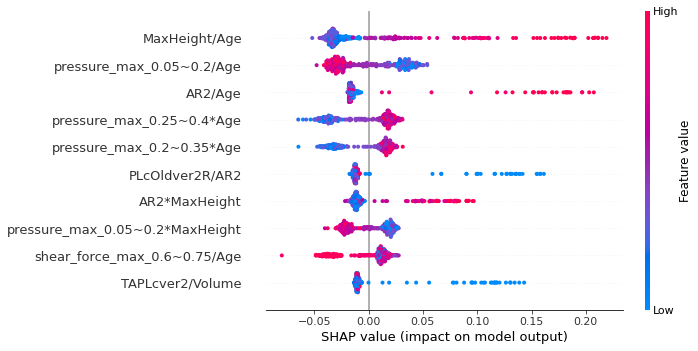

In [24]:
#修論で言うところの特徴評価用予測
#LightGBMの予測
#parのリストに値を追加することでグリッドサーチの範囲を指定できる
#すでに入っているパラメータが修論の最適パラメータ
par = []
par.append([0.025])#learning_rate
par.append([70])#n_estimators
par.append([3])#max_depth
par.append([0.07])#feature_fraction
par.append([6])#num_leaves
par.append([14])#max_bin
params = []
for p in list(itertools.product(*par)):

    params.append({
                'alg_name':'lgbm',
                'thre_ratio':0.6,
                'learning_rate':p[0],
                'n_estimators':p[1],
                'max_depth':p[2],
                'feature_fraction':p[3],                
                'num_leaves':p[4], 
                'max_bin': p[5],
            })
params2 = []
random_num = 50
av_num = 0
re_li1, pre_val_li1, score_list1, aucs1, shap_value_li1, expectead_value_li1 = run_ML(random_num, x, y, params, params2, av_num)
ii = find_best_param(aucs1, score_list1, params)
es_total1 = output_shap(x, y, shap_value_li1, ii)

0
*************************model 0 phase 0*************************
******
train AUC: 0.995
AV AUC: 0.979
Thre, Rec, Spe: 0.125 1.0 0.977
test AUC: 0.877
test score: 0.8 0.75
******
train AUC: 0.992
AV AUC: 0.969
Thre, Rec, Spe: 0.104 1.0 0.95
test AUC: 0.555
test score: 0.6 0.591
******
train AUC: 0.994
AV AUC: 0.986
Thre, Rec, Spe: 0.127 1.0 0.969
test AUC: 0.786
test score: 0.8 0.814
******
train AUC: 0.992
AV AUC: 0.986
Thre, Rec, Spe: 0.117 1.0 0.969
test AUC: 0.753
test score: 0.6 0.837
******
train AUC: 0.993
AV AUC: 0.987
Thre, Rec, Spe: 0.119 1.0 0.969
test AUC: 0.865
test score: 0.6 0.837
******
train AUC: 0.997
AV AUC: 0.988
Thre, Rec, Spe: 0.12 1.0 0.981
test AUC: 0.907
test score: 1.0 0.698
******
train AUC: 0.991
AV AUC: 0.985
Thre, Rec, Spe: 0.115 1.0 0.973
test AUC: 0.767
test score: 0.8 0.744
*****************************************************************
1
*************************model 0 phase 0*************************
******
train AUC: 0.995
AV AUC: 0.993
Thre, R

train AUC: 0.991
AV AUC: 0.968
Thre, Rec, Spe: 0.104 1.0 0.958
test AUC: 0.856
test score: 0.8 0.698
******
train AUC: 0.992
AV AUC: 0.978
Thre, Rec, Spe: 0.11 1.0 0.962
test AUC: 0.847
test score: 0.8 0.581
******
train AUC: 0.993
AV AUC: 0.973
Thre, Rec, Spe: 0.106 1.0 0.95
test AUC: 0.828
test score: 0.8 0.721
******
train AUC: 0.993
AV AUC: 0.986
Thre, Rec, Spe: 0.11 1.0 0.962
test AUC: 0.595
test score: 0.6 0.605
******
train AUC: 0.995
AV AUC: 0.981
Thre, Rec, Spe: 0.119 1.0 0.969
test AUC: 0.665
test score: 0.6 0.721
*****************************************************************
10
*************************model 0 phase 0*************************
******
train AUC: 0.994
AV AUC: 0.992
Thre, Rec, Spe: 0.117 1.0 0.965
test AUC: 0.745
test score: 0.8 0.773
******
train AUC: 0.993
AV AUC: 0.985
Thre, Rec, Spe: 0.125 1.0 0.973
test AUC: 0.777
test score: 0.6 0.818
******
train AUC: 0.992
AV AUC: 0.955
Thre, Rec, Spe: 0.115 1.0 0.969
test AUC: 0.777
test score: 0.8 0.721
******
trai

train AUC: 0.994
AV AUC: 0.992
Thre, Rec, Spe: 0.116 1.0 0.962
test AUC: 0.693
test score: 0.6 0.791
******
train AUC: 0.989
AV AUC: 0.978
Thre, Rec, Spe: 0.116 1.0 0.973
test AUC: 0.884
test score: 1.0 0.698
******
train AUC: 0.991
AV AUC: 0.983
Thre, Rec, Spe: 0.103 1.0 0.962
test AUC: 0.847
test score: 0.8 0.744
*****************************************************************
19
*************************model 0 phase 0*************************
******
train AUC: 0.994
AV AUC: 0.957
Thre, Rec, Spe: 0.116 1.0 0.958
test AUC: 0.618
test score: 0.4 0.864
******
train AUC: 0.991
AV AUC: 0.971
Thre, Rec, Spe: 0.117 1.0 0.961
test AUC: 0.836
test score: 0.8 0.705
******
train AUC: 0.992
AV AUC: 0.967
Thre, Rec, Spe: 0.127 1.0 0.973
test AUC: 0.795
test score: 0.8 0.605
******
train AUC: 0.992
AV AUC: 0.986
Thre, Rec, Spe: 0.112 1.0 0.965
test AUC: 0.981
test score: 1.0 0.674
******
train AUC: 0.996
AV AUC: 0.991
Thre, Rec, Spe: 0.119 1.0 0.965
test AUC: 0.707
test score: 0.6 0.837
******
t

train AUC: 0.99
AV AUC: 0.977
Thre, Rec, Spe: 0.124 1.0 0.969
test AUC: 0.753
test score: 0.6 0.791
*****************************************************************
28
*************************model 0 phase 0*************************
******
train AUC: 0.992
AV AUC: 0.989
Thre, Rec, Spe: 0.109 1.0 0.969
test AUC: 0.932
test score: 1.0 0.682
******
train AUC: 0.993
AV AUC: 0.998
Thre, Rec, Spe: 0.107 1.0 0.958
test AUC: 0.886
test score: 0.8 0.705
******
train AUC: 0.992
AV AUC: 0.971
Thre, Rec, Spe: 0.107 1.0 0.954
test AUC: 0.512
test score: 0.4 0.721
******
train AUC: 0.995
AV AUC: 0.962
Thre, Rec, Spe: 0.113 1.0 0.958
test AUC: 0.507
test score: 0.2 0.674
******
train AUC: 0.996
AV AUC: 0.992
Thre, Rec, Spe: 0.122 1.0 0.981
test AUC: 0.949
test score: 1.0 0.837
******
train AUC: 0.992
AV AUC: 0.985
Thre, Rec, Spe: 0.114 1.0 0.973
test AUC: 0.8
test score: 0.8 0.674
******
train AUC: 0.993
AV AUC: 0.978
Thre, Rec, Spe: 0.116 1.0 0.965
test AUC: 0.814
test score: 0.8 0.651
***********

train AUC: 0.994
AV AUC: 0.982
Thre, Rec, Spe: 0.123 1.0 0.969
test AUC: 0.718
test score: 0.8 0.727
******
train AUC: 0.99
AV AUC: 0.97
Thre, Rec, Spe: 0.112 1.0 0.961
test AUC: 0.786
test score: 0.8 0.795
******
train AUC: 0.993
AV AUC: 0.943
Thre, Rec, Spe: 0.121 1.0 0.958
test AUC: 0.93
test score: 1.0 0.581
******
train AUC: 0.991
AV AUC: 0.982
Thre, Rec, Spe: 0.12 1.0 0.969
test AUC: 0.786
test score: 0.8 0.791
******
train AUC: 0.996
AV AUC: 0.982
Thre, Rec, Spe: 0.105 1.0 0.946
test AUC: 0.814
test score: 0.8 0.814
******
train AUC: 0.993
AV AUC: 0.991
Thre, Rec, Spe: 0.115 1.0 0.965
test AUC: 0.879
test score: 0.6 0.93
******
train AUC: 0.992
AV AUC: 0.966
Thre, Rec, Spe: 0.118 1.0 0.954
test AUC: 0.74
test score: 0.6 0.605
*****************************************************************
38
*************************model 0 phase 0*************************
******
train AUC: 0.994
AV AUC: 0.996
Thre, Rec, Spe: 0.105 1.0 0.969
test AUC: 0.741
test score: 0.8 0.682
******
train A

train AUC: 0.995
AV AUC: 0.993
Thre, Rec, Spe: 0.118 1.0 0.977
test AUC: 0.888
test score: 1.0 0.698
******
train AUC: 0.992
AV AUC: 0.979
Thre, Rec, Spe: 0.123 1.0 0.973
test AUC: 0.609
test score: 0.6 0.558
******
train AUC: 0.992
AV AUC: 0.971
Thre, Rec, Spe: 0.114 1.0 0.965
test AUC: 0.642
test score: 0.2 0.791
******
train AUC: 0.99
AV AUC: 0.943
Thre, Rec, Spe: 0.109 1.0 0.95
test AUC: 0.726
test score: 0.6 0.651
******
train AUC: 0.992
AV AUC: 0.978
Thre, Rec, Spe: 0.119 1.0 0.954
test AUC: 0.842
test score: 0.8 0.837
*****************************************************************
47
*************************model 0 phase 0*************************
******
train AUC: 0.993
AV AUC: 0.984
Thre, Rec, Spe: 0.11 1.0 0.958
test AUC: 0.768
test score: 0.6 0.727
******
train AUC: 0.993
AV AUC: 0.986
Thre, Rec, Spe: 0.123 1.0 0.973
test AUC: 0.7
test score: 0.8 0.591
******
train AUC: 0.992
AV AUC: 0.978
Thre, Rec, Spe: 0.12 1.0 0.969
test AUC: 0.847
test score: 0.8 0.767
******
train A

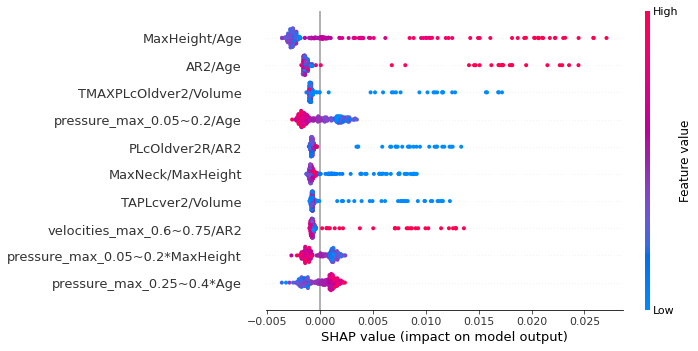

In [25]:
#RandomForestバージョン

par = []
par.append([500])#n_estimators
par.append([5])#max_depth
par.append([0.07])#max_features
par.append([2])#min_samples_split
par.append([8])#min_samples_leaf
params = []
for p in list(itertools.product(*par)):
    params.append({
                'alg_name':'rf',
                'criterion': 'entropy',
                'thre_ratio':0.5,
                'n_estimators':p[0],
                'max_depth':p[1],
                'max_features':p[2],
                'min_samples_split':p[3],
                'min_samples_leaf':p[4],                
                'n_jobs':-1
            })


params2 = []

random_num = 50
av_num = 200
re_li2, pre_val_li2, score_list2, aucs2, shap_value_li2, expectead_value_li2 = run_ML(random_num, x, y, params, params2, av_num)
ii = find_best_param(aucs2, score_list2, params)
es_total2 = output_shap(x, y, shap_value_li2, ii)


In [13]:
#MLPバージョン
#SHAP計算つけるとやたら長い（2日〜4日かかる）
par = []
par.append([(64)])#hidden_layer_sizes
par.append(["auto"])#batch_size
par.append([0.2])#learning_rate_init
par.append([200])#max_iter
par.append([1e-6])#tol
params = []
for p in list(itertools.product(*par)):
    params.append({
                'alg_name':'nn',
                'activation': 'logistic',
                'thre_ratio':0.45,
                'hidden_layer_sizes':p[0],
                'batch_size':p[1],
                'learning_rate_init':p[2],
                'max_iter':p[3],
                'tol':p[4],                
            })


params2 = []

random_num = 50
av_num = 200
re_li3, pre_val_li3, score_list3, aucs3, shap_value_li3, expectead_value_li3 = run_ML(random_num, x, y, params, params2, av_num)
ii = find_best_param(aucs3, score_list3, params)
es_total3 = output_shap(x, y, shap_value_li3, ii)


0
*************************model 0 phase 0*************************
******


KeyboardInterrupt: 

In [ ]:
#陽性サンプルの正解率出力
p1 = np.zeros(len(x))
for n in range(random_num):
    p1 +=pre_val_li1_2[0][n].values.reshape(-1)
print((p1/random_num)[:35])

In [130]:
#Texで表出力する用
for i, (a,b,c,d1) in enumerate(zip(p1,p2,p3,p4)):
    print(i + 1, "&", a/random_num, "&", b/random_num,"&", c/random_num, "&", d1/random_num, "\\\\ \hline")

1 & 1.0 & 1.0 & 1.0 & 1.0 \\ \hline
2 & 1.0 & 1.0 & 1.0 & 1.0 \\ \hline
3 & 0.0 & 0.0 & 0.04 & 0.0 \\ \hline
4 & 1.0 & 1.0 & 1.0 & 1.0 \\ \hline
5 & 1.0 & 1.0 & 0.84 & 1.0 \\ \hline
6 & 1.0 & 1.0 & 0.04 & 1.0 \\ \hline
7 & 0.96 & 0.48 & 0.08 & 0.86 \\ \hline
8 & 0.44 & 0.22 & 0.98 & 0.66 \\ \hline
9 & 1.0 & 1.0 & 0.92 & 1.0 \\ \hline
10 & 1.0 & 1.0 & 0.78 & 1.0 \\ \hline
11 & 1.0 & 1.0 & 0.6 & 1.0 \\ \hline
12 & 0.94 & 1.0 & 1.0 & 0.96 \\ \hline
13 & 0.98 & 1.0 & 0.06 & 0.98 \\ \hline
14 & 0.74 & 1.0 & 0.0 & 0.76 \\ \hline
15 & 0.84 & 0.98 & 0.98 & 0.86 \\ \hline
16 & 1.0 & 0.92 & 0.96 & 0.96 \\ \hline
17 & 1.0 & 1.0 & 0.98 & 1.0 \\ \hline
18 & 0.0 & 0.0 & 0.0 & 0.0 \\ \hline
19 & 0.64 & 0.02 & 0.02 & 0.62 \\ \hline
20 & 1.0 & 1.0 & 0.9 & 1.0 \\ \hline
21 & 0.68 & 0.0 & 0.92 & 0.68 \\ \hline
22 & 0.38 & 0.2 & 0.0 & 0.12 \\ \hline
23 & 1.0 & 1.0 & 1.0 & 0.98 \\ \hline
24 & 0.02 & 0.0 & 0.0 & 0.0 \\ \hline
25 & 0.94 & 0.98 & 1.0 & 1.0 \\ \hline
26 & 1.0 & 1.0 & 1.0 & 1.0 \\ \hline
27 & 1

In [26]:
#SHAP値に基づく特徴選択
#MLPだけ計算が長いので、別PCで回した結果を載せてます（予測性能など全て一緒なので問題ないはず）
columns_lgbm = x.columns[abs(np.sum(es_total1)).sort_values(ascending = False).index[:40]]
columns_rf = x.columns[abs(np.sum(es_total2)).sort_values(ascending = False).index[:40]]
#columns_mlp = x.columns[abs(np.sum(es_total3)).sort_values(ascending = False).index[:40]]

columns_mlp = ['DM', 'SideorBifur', 'HL', 'none', 'bleb', 'Sex', 'Smoke',
       'PLcOldver2R*Age', 'LSIR/MaxHeight', 'LSIR/MaxNeck', 'LSIR*Age',
       'PLcver2R*Age', 'LSIR', 'LSIR/AR2', 'TMAXSCI/Age',
       'pressure_max_0.55~0.6', 'TMAXSCI*Volume', 'LSIR/Volume',
       'wss_max_0.2~0.25', 'IC_choro', 'ICIR/Volume', 'PICA', 'ICIR/Age',
       'LSIR/NeckArea', 'TMINLSI*Age', 'IC_Pcom', 'pressure_max_0.05~0.2/AR2',
       'ELVR/Volume', 'TMAXSCI*MaxHeight', 'ELVR/Age',
       'pressure_max_0.65~0.8/Volume', 'pressure_max_0.05~0.2*MaxNeck',
       'velocities_max_0.5~0.65', 'velocities_max_0.05~0.2/Volume',
       'TMAXPLcver2*Age', 'ELR/Age', 'shear_force_max_0.55~0.6',
       'pressure_max_0.1~0.25/Age', 'pressure_max_0.05~0.2/Volume',
       'TMAXSAWSS*AR2']

In [28]:
#特徴選択後の結果出力
#LightGBM2
par = []
par.append([0.050])
par.append([95])
par.append([3])
par.append([0.10])
par.append([6])
par.append([14])
params = []
for p in list(itertools.product(*par)):
    params.append({
                'alg_name':'lgbm',
                'thre_ratio':0.45,
                'learning_rate':p[0],
                'n_estimators':p[1],
                'max_depth':p[2],
                'feature_fraction':p[3],                
                'num_leaves':p[4], 
                'max_bin': p[5],
            })
params2=[]
#columns = x.columns[abs(np.sum(es_total1)).sort_values(ascending = False).index[:40]]
av_num = 30 #delete feature num
re_li1_2, pre_val_li1_2, score_list1_2, aucs1_2, shap_value_li1_2, expectead_value_li1_2 = run_ML(random_num, x[columns_lgbm], y, params, params2, av_num)
ii = find_best_param(aucs1_2, score_list1_2, params)
es_total1_2 = output_shap(x[columns_lgbm], y, shap_value_li1_2, ii)

0
*************************model 0 phase 0*************************
******
train AUC: 0.997
AV AUC: 0.844
Thre, Rec, Spe: 0.118 1.0 0.973
test AUC: 0.914
test score: 0.8 0.909
******
train AUC: 0.996
AV AUC: 0.836
Thre, Rec, Spe: 0.106 1.0 0.969
test AUC: 0.859
test score: 0.6 0.909
******
train AUC: 0.996
AV AUC: 0.842
Thre, Rec, Spe: 0.087 1.0 0.965
test AUC: 0.926
test score: 0.8 0.814
******
train AUC: 0.998
AV AUC: 0.819
Thre, Rec, Spe: 0.097 1.0 0.962
test AUC: 0.902
test score: 0.8 0.884
******
train AUC: 0.997
AV AUC: 0.867
Thre, Rec, Spe: 0.095 1.0 0.969
test AUC: 0.963
test score: 1.0 0.884
******
train AUC: 0.997
AV AUC: 0.861
Thre, Rec, Spe: 0.088 1.0 0.958
test AUC: 0.94
test score: 1.0 0.767
******
train AUC: 0.999
AV AUC: 0.876
Thre, Rec, Spe: 0.114 1.0 0.992
test AUC: 0.926
test score: 1.0 0.86
*****************************************************************
1
*************************model 0 phase 0*************************
******
train AUC: 0.998
AV AUC: 0.849
Thre, 

AV AUC: 0.913
Thre, Rec, Spe: 0.096 1.0 0.965
test AUC: 0.967
test score: 1.0 0.884
******
train AUC: 0.997
AV AUC: 0.845
Thre, Rec, Spe: 0.094 1.0 0.965
test AUC: 0.949
test score: 1.0 0.814
******
train AUC: 0.997
AV AUC: 0.889
Thre, Rec, Spe: 0.082 1.0 0.954
test AUC: 0.902
test score: 0.8 0.884
******
train AUC: 0.998
AV AUC: 0.892
Thre, Rec, Spe: 0.107 1.0 0.977
test AUC: 0.763
test score: 0.4 0.791
******
train AUC: 0.998
AV AUC: 0.885
Thre, Rec, Spe: 0.068 1.0 0.958
test AUC: 0.851
test score: 0.8 0.767
*****************************************************************
10
*************************model 0 phase 0*************************
******
train AUC: 0.996
AV AUC: 0.851
Thre, Rec, Spe: 0.085 1.0 0.954
test AUC: 0.914
test score: 0.8 0.864
******
train AUC: 0.997
AV AUC: 0.852
Thre, Rec, Spe: 0.094 1.0 0.973
test AUC: 0.955
test score: 0.8 0.886
******
train AUC: 0.998
AV AUC: 0.838
Thre, Rec, Spe: 0.085 1.0 0.965
test AUC: 0.865
test score: 0.6 0.837
******
train AUC: 0.997
A

train AUC: 0.997
AV AUC: 0.807
Thre, Rec, Spe: 0.097 1.0 0.965
test AUC: 0.916
test score: 0.8 0.814
******
train AUC: 0.995
AV AUC: 0.885
Thre, Rec, Spe: 0.073 1.0 0.946
test AUC: 0.967
test score: 1.0 0.767
*****************************************************************
19
*************************model 0 phase 0*************************
******
train AUC: 0.997
AV AUC: 0.896
Thre, Rec, Spe: 0.082 1.0 0.958
test AUC: 0.859
test score: 0.8 0.818
******
train AUC: 0.998
AV AUC: 0.862
Thre, Rec, Spe: 0.097 1.0 0.981
test AUC: 0.895
test score: 1.0 0.795
******
train AUC: 0.995
AV AUC: 0.849
Thre, Rec, Spe: 0.071 1.0 0.942
test AUC: 0.958
test score: 1.0 0.698
******
train AUC: 0.997
AV AUC: 0.853
Thre, Rec, Spe: 0.098 1.0 0.973
test AUC: 0.986
test score: 1.0 0.837
******
train AUC: 0.998
AV AUC: 0.858
Thre, Rec, Spe: 0.085 1.0 0.958
test AUC: 0.809
test score: 0.6 0.86
******
train AUC: 0.998
AV AUC: 0.895
Thre, Rec, Spe: 0.095 1.0 0.969
test AUC: 0.995
test score: 1.0 0.907
******
tr

AV AUC: 0.886
Thre, Rec, Spe: 0.099 1.0 0.961
test AUC: 0.923
test score: 0.8 0.841
******
train AUC: 0.997
AV AUC: 0.889
Thre, Rec, Spe: 0.082 1.0 0.962
test AUC: 0.833
test score: 0.8 0.86
******
train AUC: 0.998
AV AUC: 0.826
Thre, Rec, Spe: 0.136 0.967 0.988
test AUC: 0.721
test score: 0.6 0.86
******
train AUC: 0.998
AV AUC: 0.859
Thre, Rec, Spe: 0.083 1.0 0.962
test AUC: 0.981
test score: 1.0 0.837
******
train AUC: 0.997
AV AUC: 0.81
Thre, Rec, Spe: 0.079 1.0 0.965
test AUC: 0.912
test score: 0.8 0.814
******
train AUC: 0.997
AV AUC: 0.911
Thre, Rec, Spe: 0.086 1.0 0.969
test AUC: 0.935
test score: 1.0 0.791
*****************************************************************
29
*************************model 0 phase 0*************************
******
train AUC: 0.997
AV AUC: 0.866
Thre, Rec, Spe: 0.09 1.0 0.958
test AUC: 0.95
test score: 1.0 0.841
******
train AUC: 0.997
AV AUC: 0.826
Thre, Rec, Spe: 0.097 1.0 0.958
test AUC: 0.9
test score: 0.6 0.886
******
train AUC: 0.998
AV AUC

AV AUC: 0.88
Thre, Rec, Spe: 0.083 1.0 0.962
test AUC: 0.851
test score: 0.8 0.814
******
train AUC: 0.997
AV AUC: 0.858
Thre, Rec, Spe: 0.085 1.0 0.958
test AUC: 0.94
test score: 0.8 0.907
******
train AUC: 0.997
AV AUC: 0.859
Thre, Rec, Spe: 0.094 1.0 0.969
test AUC: 1.0
test score: 1.0 0.93
******
train AUC: 0.995
AV AUC: 0.864
Thre, Rec, Spe: 0.085 1.0 0.954
test AUC: 0.935
test score: 1.0 0.767
*****************************************************************
38
*************************model 0 phase 0*************************
******
train AUC: 0.998
AV AUC: 0.852
Thre, Rec, Spe: 0.138 0.967 0.988
test AUC: 0.882
test score: 0.6 0.909
******
train AUC: 0.997
AV AUC: 0.843
Thre, Rec, Spe: 0.109 0.967 0.981
test AUC: 0.85
test score: 0.6 0.864
******
train AUC: 0.996
AV AUC: 0.918
Thre, Rec, Spe: 0.108 1.0 0.973
test AUC: 0.907
test score: 1.0 0.837
******
train AUC: 0.998
AV AUC: 0.826
Thre, Rec, Spe: 0.088 1.0 0.973
test AUC: 0.856
test score: 0.8 0.884
******
train AUC: 0.997
AV 

train AUC: 0.997
AV AUC: 0.878
Thre, Rec, Spe: 0.083 1.0 0.95
test AUC: 0.86
test score: 0.8 0.791
******
train AUC: 0.994
AV AUC: 0.881
Thre, Rec, Spe: 0.077 1.0 0.946
test AUC: 0.958
test score: 1.0 0.837
*****************************************************************
47
*************************model 0 phase 0*************************
******
train AUC: 0.997
AV AUC: 0.812
Thre, Rec, Spe: 0.074 1.0 0.95
test AUC: 0.905
test score: 0.8 0.75
******
train AUC: 0.996
AV AUC: 0.873
Thre, Rec, Spe: 0.081 1.0 0.95
test AUC: 0.855
test score: 0.8 0.659
******
train AUC: 0.997
AV AUC: 0.845
Thre, Rec, Spe: 0.094 1.0 0.965
test AUC: 0.953
test score: 1.0 0.837
******
train AUC: 0.998
AV AUC: 0.824
Thre, Rec, Spe: 0.085 1.0 0.958
test AUC: 0.93
test score: 0.8 0.907
******
train AUC: 0.996
AV AUC: 0.86
Thre, Rec, Spe: 0.089 1.0 0.962
test AUC: 0.888
test score: 0.6 0.791
******
train AUC: 0.994
AV AUC: 0.886
Thre, Rec, Spe: 0.088 0.967 0.958
test AUC: 0.912
test score: 0.8 0.791
******
train 

IndexError: list index out of range

In [29]:
#RF2-2
par = []
par.append([150])
par.append([3])
par.append([0.07])
par.append([2])
par.append([8])
params = []
for p in list(itertools.product(*par)):
    params.append({
                'alg_name':'rf',
                'criterion': 'entropy',
                'thre_ratio':0.8,
                'n_estimators':p[0],
                'max_depth':p[1],
                'max_features':p[2],
                'min_samples_split':p[3],
                'min_samples_leaf':p[4],                
                'n_jobs':-1
            })
random_num = 50
av_num = 10
#columns = x.columns[abs(np.sum(es_total2)).sort_values(ascending = False).index[:40]]
re_li2_2, pre_val_li2_2, score_list2_2, aucs2_2, shap_value_li2_2, expectead_value_li2_2 = run_ML(random_num, x[columns_rf], y, params, params2,av_num)
ii = find_best_param(aucs2_2, score_list2_2, params)
es_total2_2 = output_shap(x[columns_rf], y, shap_value_li2_2, ii)




0
*************************model 0 phase 0*************************
******
train AUC: 0.95
AV AUC: 0.852
Thre, Rec, Spe: 0.105 0.9 0.896
test AUC: 0.936
test score: 1.0 0.727
******
train AUC: 0.954
AV AUC: 0.858
Thre, Rec, Spe: 0.121 0.867 0.903
test AUC: 0.75
test score: 0.6 0.795
******
train AUC: 0.959
AV AUC: 0.895
Thre, Rec, Spe: 0.098 0.967 0.869
test AUC: 0.884
test score: 0.8 0.674
******
train AUC: 0.957
AV AUC: 0.919
Thre, Rec, Spe: 0.115 0.9 0.912
test AUC: 0.828
test score: 0.6 0.86
******
train AUC: 0.954
AV AUC: 0.882
Thre, Rec, Spe: 0.121 0.867 0.923
test AUC: 0.912
test score: 0.8 0.837
******
train AUC: 0.955
AV AUC: 0.913
Thre, Rec, Spe: 0.135 0.867 0.935
test AUC: 0.981
test score: 1.0 0.907
******
train AUC: 0.959
AV AUC: 0.917
Thre, Rec, Spe: 0.123 0.867 0.927
test AUC: 0.833
test score: 0.8 0.884
*****************************************************************
1
*************************model 0 phase 0*************************
******
train AUC: 0.948
AV AUC: 0.8

train AUC: 0.956
AV AUC: 0.852
Thre, Rec, Spe: 0.121 0.867 0.919
test AUC: 0.964
test score: 1.0 0.841
******
train AUC: 0.953
AV AUC: 0.877
Thre, Rec, Spe: 0.12 0.9 0.912
test AUC: 0.935
test score: 0.8 0.837
******
train AUC: 0.956
AV AUC: 0.884
Thre, Rec, Spe: 0.127 0.867 0.927
test AUC: 0.856
test score: 0.6 0.721
******
train AUC: 0.952
AV AUC: 0.906
Thre, Rec, Spe: 0.105 0.9 0.877
test AUC: 0.851
test score: 0.8 0.698
******
train AUC: 0.959
AV AUC: 0.919
Thre, Rec, Spe: 0.13 0.9 0.923
test AUC: 0.758
test score: 0.4 0.767
******
train AUC: 0.962
AV AUC: 0.87
Thre, Rec, Spe: 0.114 0.9 0.904
test AUC: 0.828
test score: 0.6 0.791
*****************************************************************
10
*************************model 0 phase 0*************************
******
train AUC: 0.951
AV AUC: 0.907
Thre, Rec, Spe: 0.12 0.9 0.907
test AUC: 0.882
test score: 0.8 0.932
******
train AUC: 0.947
AV AUC: 0.898
Thre, Rec, Spe: 0.114 0.867 0.911
test AUC: 0.886
test score: 0.6 0.841
******

train AUC: 0.958
AV AUC: 0.886
Thre, Rec, Spe: 0.096 0.933 0.873
test AUC: 0.935
test score: 1.0 0.651
******
train AUC: 0.947
AV AUC: 0.872
Thre, Rec, Spe: 0.107 0.867 0.896
test AUC: 0.753
test score: 0.4 0.698
******
train AUC: 0.955
AV AUC: 0.883
Thre, Rec, Spe: 0.088 0.933 0.862
test AUC: 0.851
test score: 0.8 0.744
******
train AUC: 0.946
AV AUC: 0.863
Thre, Rec, Spe: 0.117 0.9 0.908
test AUC: 0.935
test score: 0.8 0.884
*****************************************************************
19
*************************model 0 phase 0*************************
******
train AUC: 0.96
AV AUC: 0.908
Thre, Rec, Spe: 0.124 0.933 0.927
test AUC: 0.714
test score: 0.2 0.818
******
train AUC: 0.952
AV AUC: 0.862
Thre, Rec, Spe: 0.112 0.867 0.915
test AUC: 0.873
test score: 0.6 0.795
******
train AUC: 0.952
AV AUC: 0.883
Thre, Rec, Spe: 0.082 0.967 0.819
test AUC: 0.93
test score: 1.0 0.512
******
train AUC: 0.946
AV AUC: 0.893
Thre, Rec, Spe: 0.102 0.867 0.9
test AUC: 0.986
test score: 1.0 0.79

train AUC: 0.957
AV AUC: 0.874
Thre, Rec, Spe: 0.131 0.9 0.915
test AUC: 0.577
test score: 0.4 0.814
******
train AUC: 0.957
AV AUC: 0.885
Thre, Rec, Spe: 0.079 1.0 0.827
test AUC: 0.744
test score: 0.8 0.674
*****************************************************************
28
*************************model 0 phase 0*************************
******
train AUC: 0.963
AV AUC: 0.904
Thre, Rec, Spe: 0.092 1.0 0.853
test AUC: 0.941
test score: 1.0 0.705
******
train AUC: 0.959
AV AUC: 0.915
Thre, Rec, Spe: 0.098 0.933 0.888
test AUC: 0.936
test score: 1.0 0.568
******
train AUC: 0.959
AV AUC: 0.905
Thre, Rec, Spe: 0.12 0.9 0.927
test AUC: 0.684
test score: 0.4 0.744
******
train AUC: 0.954
AV AUC: 0.912
Thre, Rec, Spe: 0.126 0.9 0.919
test AUC: 0.679
test score: 0.4 0.837
******
train AUC: 0.953
AV AUC: 0.914
Thre, Rec, Spe: 0.106 0.867 0.904
test AUC: 0.958
test score: 1.0 0.791
******
train AUC: 0.954
AV AUC: 0.904
Thre, Rec, Spe: 0.111 0.9 0.908
test AUC: 0.87
test score: 0.8 0.791
******

train AUC: 0.953
AV AUC: 0.935
Thre, Rec, Spe: 0.114 0.9 0.911
test AUC: 0.764
test score: 0.6 0.659
******
train AUC: 0.946
AV AUC: 0.881
Thre, Rec, Spe: 0.103 0.867 0.907
test AUC: 0.855
test score: 0.6 0.773
******
train AUC: 0.96
AV AUC: 0.874
Thre, Rec, Spe: 0.093 0.933 0.865
test AUC: 0.967
test score: 1.0 0.605
******
train AUC: 0.955
AV AUC: 0.901
Thre, Rec, Spe: 0.101 0.9 0.888
test AUC: 0.847
test score: 0.8 0.744
******
train AUC: 0.95
AV AUC: 0.855
Thre, Rec, Spe: 0.129 0.9 0.923
test AUC: 0.856
test score: 0.8 0.86
******
train AUC: 0.95
AV AUC: 0.892
Thre, Rec, Spe: 0.098 0.9 0.877
test AUC: 0.921
test score: 0.8 0.907
******
train AUC: 0.95
AV AUC: 0.865
Thre, Rec, Spe: 0.107 0.9 0.904
test AUC: 0.795
test score: 0.6 0.698
*****************************************************************
38
*************************model 0 phase 0*************************
******
train AUC: 0.952
AV AUC: 0.923
Thre, Rec, Spe: 0.106 0.9 0.9
test AUC: 0.85
test score: 0.8 0.795
******
train

train AUC: 0.958
AV AUC: 0.911
Thre, Rec, Spe: 0.113 0.867 0.931
test AUC: 0.921
test score: 1.0 0.767
******
train AUC: 0.959
AV AUC: 0.933
Thre, Rec, Spe: 0.079 1.0 0.815
test AUC: 0.772
test score: 0.8 0.512
******
train AUC: 0.957
AV AUC: 0.931
Thre, Rec, Spe: 0.109 0.9 0.912
test AUC: 0.823
test score: 0.4 0.86
******
train AUC: 0.956
AV AUC: 0.88
Thre, Rec, Spe: 0.109 0.9 0.908
test AUC: 0.753
test score: 0.6 0.698
******
train AUC: 0.962
AV AUC: 0.911
Thre, Rec, Spe: 0.106 0.933 0.912
test AUC: 0.884
test score: 0.6 0.814
*****************************************************************
47
*************************model 0 phase 0*************************
******
train AUC: 0.961
AV AUC: 0.88
Thre, Rec, Spe: 0.089 0.967 0.857
test AUC: 0.886
test score: 0.8 0.682
******
train AUC: 0.96
AV AUC: 0.878
Thre, Rec, Spe: 0.116 0.9 0.923
test AUC: 0.773
test score: 0.8 0.614
******
train AUC: 0.961
AV AUC: 0.89
Thre, Rec, Spe: 0.11 0.9 0.919
test AUC: 0.893
test score: 0.8 0.767
******
t

IndexError: list index out of range

In [30]:
#MLP2-2
par = []
par.append([(128)])#hidden_layer_sizes
par.append(["auto"])#batch_size
par.append([0.1])#learning_rate_init
par.append([100])#max_iter
par.append([1e-4])#tol
params = []
for p in list(itertools.product(*par)):
    params.append({
                'alg_name':'nn',
                'activation': 'logistic',
                'thre_ratio':0.01,
                'hidden_layer_sizes':p[0],
                'batch_size':p[1],
                'learning_rate_init':p[2],
                'max_iter':p[3],
                'tol':p[4],                
            })


    params2 = []

random_num = 50
av_num = 200

re_li3_2, pre_val_li3_2, score_list3_2, aucs3_2, shap_value_li3_2, expectead_value_li3_2 = run_ML(random_num, x[columns_mlp], y, params, params2, av_num)
ii = find_best_param(aucs3_2, score_list3_2, params)
es_total3_2 = output_shap(x[columns_mlp], y, shap_value_li3_2, ii)

0
*************************model 0 phase 0*************************
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.841
test score: 0.8 0.727
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.01 1.0 1.0
test AUC: 0.936
test score: 0.8 0.932
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.007 1.0 1.0
test AUC: 0.749
test score: 0.6 0.86
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.721
test score: 0.4 0.884
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.008 1.0 1.0
test AUC: 0.791
test score: 0.6 0.837
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.744
test score: 0.6 0.767
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.926
test score: 0.8 0.837
*****************************************************************
1
*************************model 0 phase 0*************************
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.855
test s

train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.809
test score: 0.6 0.907
*****************************************************************
10
*************************model 0 phase 0*************************
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.868
test score: 0.8 0.932
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.01 1.0 1.0
test AUC: 0.786
test score: 0.6 0.886
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.73
test score: 0.4 0.814
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.772
test score: 0.8 0.628
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.93
test score: 0.6 0.907
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.01 1.0 1.0
test AUC: 0.953
test score: 0.8 0.953
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.01 1.0 1.0
test AUC: 0.93
test score: 1.0 0.814
**************************************************************

train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.007 1.0 1.0
test AUC: 0.698
test score: 0.2 0.837
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.786
test score: 0.6 0.86
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.01 1.0 1.0
test AUC: 0.795
test score: 0.8 0.791
*****************************************************************
20
*************************model 0 phase 0*************************
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.968
test score: 1.0 0.818
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.973
test score: 1.0 0.841
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.949
test score: 1.0 0.791
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.01 1.0 1.0
test AUC: 0.707
test score: 0.4 0.86
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.01 1.0 1.0
test AUC: 0.712
test score: 0.4 0.884
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1

train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.856
test score: 0.8 0.814
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.791
test score: 0.4 0.93
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.781
test score: 0.6 0.837
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.926
test score: 0.8 0.86
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.898
test score: 0.8 0.814
*****************************************************************
30
*************************model 0 phase 0*************************
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.01 1.0 1.0
test AUC: 0.927
test score: 0.6 0.909
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.759
test score: 0.4 0.795
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.01 1.0 1.0
test AUC: 0.995
test score: 1.0 0.86
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1

train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.714
test score: 0.4 0.886
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.773
test score: 0.8 0.705
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.847
test score: 0.8 0.86
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.921
test score: 1.0 0.721
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.823
test score: 0.6 0.767
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.007 1.0 1.0
test AUC: 0.986
test score: 1.0 0.86
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.795
test score: 0.4 0.814
*****************************************************************
40
*************************model 0 phase 0*************************
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.891
test score: 0.8 0.818
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.

train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.949
test score: 1.0 0.837
*****************************************************************
49
*************************model 0 phase 0*************************
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.882
test score: 0.8 0.841
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.01 1.0 1.0
test AUC: 0.909
test score: 0.8 0.795
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.008 1.0 1.0
test AUC: 0.74
test score: 0.2 0.907
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.605
test score: 0.2 0.791
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.819
test score: 0.6 0.791
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.949
test score: 1.0 0.86
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.009 1.0 1.0
test AUC: 0.809
test score: 0.8 0.814
***********************************************************

IndexError: list index out of range

In [31]:
#スタッキングを行うための関数
def stacking_ML(random_num, x, y, params, params2,av_num):
    n_model=[len(params), len(params2)]
    pre_li=[[] for i in range(sum(n_model))]
    pre_val_li=[[] for i in range(sum(n_model))]
    score_list=[[] for i in range(sum(n_model))]
    aucs=[[] for i in range(sum(n_model))]
    shap_value_li=[[] for i in range(sum(n_model))]
    expected_value_li=[[] for i in range(sum(n_model))]
    for n in range(random_num):
        phase=0
        print(n)
        
        for i in range(n_model[0]):
            x_2 = x.copy()[columns_lgbm]
            pre_val_data = pd.concat([pre_val_li1_2[0][n], pre_val_li2_2[0][n],pre_val_li3_2[0][n]],axis = 1)
            pre_val_data.columns = ["lgbm","rf", "mlp"]
            x_2 = pd.concat([x_2, pre_val_data], axis = 1)
            mes='*************************model '+str(i)+' phase '+str(phase)+'*************************'
            print(mes)
            param=params[i].copy()
            param['random_state']=2*n
            pre,pre_val,auc,thres,shap_v,expected_v=ML(x_2,y,param,av_num,'all')

            pre_li[i].append(pd.DataFrame(pre))
            pre_val_li[i].append(pd.DataFrame(pre_val))
            print('*'*len(mes))

            #score
            score_list[i].append([mtr.recall_score(y,pre_val),mtr.recall_score(y,pre_val,pos_label=0)])
            aucs[i].append(auc)
            shap_value_li[i].append(shap_v)
            expected_value_li[i].append(expected_v)

    for i in range(sum(n_model)):
        

        auc=np.array(aucs[i][:].copy())
        recs=np.array(score_list[i].copy())[:,0]
        spes=np.array(score_list[i].copy())[:,1]

        print('AUC ave:',round(np.mean(auc[:,0]),3),round(np.mean(auc[:,1]),3))
        print('score:',round(np.mean(recs),3),round(np.mean(spes),3))
        
    return pre_li, pre_val_li, score_list, aucs, shap_value_li, expected_value_li

In [32]:
#stacking結果の出力
par = []
par.append([0.07])
par.append([100])
par.append([3])
par.append([0.05])
par.append([6])
par.append([14])
params = []
for p in list(itertools.product(*par)):
    params.append({
                'alg_name':'lgbm',
                'thre_ratio':0.35,
                'learning_rate':p[0],
                'n_estimators':p[1],
                'max_depth':p[2],
                'feature_fraction':p[3],                
                'num_leaves':p[4], 
                'max_bin': p[5],
            })
params2=[]
random_num = 50
av_num = 200

re_li4, pre_val_li4, score_list4, aucs4, shap_value_li4, expectead_value_li4 = stacking_ML(random_num, x, y, params, params2, av_num)
ii = find_best_param(aucs4, score_list4, params)
#es_total4 = output_shap(x[columns_lgbm], y, ii)

0
*************************model 0 phase 0*************************
******
train AUC: 0.999
AV AUC: 0.5
Thre, Rec, Spe: 0.1 1.0 0.988
test AUC: 0.968
test score: 1.0 0.841
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.093 1.0 0.981
test AUC: 0.886
test score: 0.8 0.864
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.063 1.0 0.962
test AUC: 0.902
test score: 0.8 0.698
******
train AUC: 0.999
AV AUC: 0.5
Thre, Rec, Spe: 0.106 1.0 0.992
test AUC: 0.893
test score: 0.6 0.907
******
train AUC: 0.999
AV AUC: 0.5
Thre, Rec, Spe: 0.098 1.0 0.988
test AUC: 0.944
test score: 0.8 0.907
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.083 1.0 0.981
test AUC: 0.953
test score: 1.0 0.791
******
train AUC: 0.999
AV AUC: 0.5
Thre, Rec, Spe: 0.083 1.0 0.988
test AUC: 0.93
test score: 1.0 0.814
*****************************************************************
1
*************************model 0 phase 0*************************
******
train AUC: 0.999
AV AUC: 0.5
Thre, Rec, Spe: 0.093 1

Thre, Rec, Spe: 0.099 1.0 0.985
test AUC: 0.949
test score: 1.0 0.814
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.074 1.0 0.969
test AUC: 0.865
test score: 0.8 0.86
******
train AUC: 0.999
AV AUC: 0.5
Thre, Rec, Spe: 0.091 1.0 0.977
test AUC: 0.805
test score: 0.4 0.791
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.063 1.0 0.965
test AUC: 0.865
test score: 0.8 0.721
*****************************************************************
10
*************************model 0 phase 0*************************
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.097 1.0 0.981
test AUC: 0.918
test score: 0.8 0.932
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.074 1.0 0.965
test AUC: 0.886
test score: 0.8 0.773
******
train AUC: 0.999
AV AUC: 0.5
Thre, Rec, Spe: 0.072 1.0 0.981
test AUC: 0.86
test score: 0.6 0.837
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.059 1.0 0.962
test AUC: 0.73
test score: 0.6 0.628
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.08

AV AUC: 0.5
Thre, Rec, Spe: 0.087 0.967 0.988
test AUC: 0.873
test score: 0.8 0.795
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.083 1.0 0.988
test AUC: 0.914
test score: 1.0 0.818
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.099 1.0 0.985
test AUC: 0.94
test score: 1.0 0.791
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.102 1.0 0.988
test AUC: 0.977
test score: 1.0 0.884
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.11 1.0 0.992
test AUC: 0.819
test score: 0.6 0.837
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.089 1.0 0.988
test AUC: 0.981
test score: 1.0 0.93
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.074 1.0 0.981
test AUC: 0.851
test score: 0.8 0.767
*****************************************************************
20
*************************model 0 phase 0*************************
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.088 1.0 0.981
test AUC: 0.982
test score: 1.0 0.795
******
train AUC: 0.998
AV AUC: 0.5
Thre, Re

AV AUC: 0.5
Thre, Rec, Spe: 0.085 1.0 0.977
test AUC: 0.981
test score: 1.0 0.837
******
train AUC: 0.997
AV AUC: 0.5
Thre, Rec, Spe: 0.068 1.0 0.958
test AUC: 0.93
test score: 0.8 0.837
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.106 1.0 0.992
test AUC: 0.916
test score: 0.8 0.837
*****************************************************************
29
*************************model 0 phase 0*************************
******
train AUC: 0.996
AV AUC: 0.5
Thre, Rec, Spe: 0.064 1.0 0.954
test AUC: 0.968
test score: 1.0 0.727
******
train AUC: 0.995
AV AUC: 0.5
Thre, Rec, Spe: 0.065 1.0 0.95
test AUC: 0.818
test score: 0.6 0.864
******
train AUC: 0.999
AV AUC: 0.5
Thre, Rec, Spe: 0.09 1.0 0.985
test AUC: 0.795
test score: 0.6 0.814
******
train AUC: 0.995
AV AUC: 0.5
Thre, Rec, Spe: 0.057 1.0 0.942
test AUC: 0.977
test score: 1.0 0.791
******
train AUC: 0.996
AV AUC: 0.5
Thre, Rec, Spe: 0.06 1.0 0.954
test AUC: 0.842
test score: 0.8 0.721
******
train AUC: 0.996
AV AUC: 0.5
Thre, Rec, 

AV AUC: 0.5
Thre, Rec, Spe: 0.081 1.0 0.973
test AUC: 0.845
test score: 0.8 0.841
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.072 1.0 0.962
test AUC: 0.921
test score: 1.0 0.767
******
train AUC: 0.997
AV AUC: 0.5
Thre, Rec, Spe: 0.08 1.0 0.977
test AUC: 0.935
test score: 0.8 0.86
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.088 1.0 0.985
test AUC: 0.958
test score: 1.0 0.86
******
train AUC: 0.996
AV AUC: 0.5
Thre, Rec, Spe: 0.049 1.0 0.938
test AUC: 0.856
test score: 0.8 0.674
******
train AUC: 0.999
AV AUC: 0.5
Thre, Rec, Spe: 0.103 1.0 0.985
test AUC: 0.944
test score: 0.8 0.907
*****************************************************************
39
*************************model 0 phase 0*************************
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.075 1.0 0.969
test AUC: 0.85
test score: 0.2 0.932
******
train AUC: 1.0
AV AUC: 0.5
Thre, Rec, Spe: 0.093 1.0 0.988
test AUC: 0.914
test score: 0.8 0.795
******
train AUC: 0.999
AV AUC: 0.5
Thre, Rec, 

train AUC: 0.999
AV AUC: 0.5
Thre, Rec, Spe: 0.102 1.0 0.992
test AUC: 0.935
test score: 1.0 0.814
*****************************************************************
48
*************************model 0 phase 0*************************
******
train AUC: 0.996
AV AUC: 0.5
Thre, Rec, Spe: 0.056 1.0 0.946
test AUC: 0.932
test score: 0.8 0.75
******
train AUC: 0.997
AV AUC: 0.5
Thre, Rec, Spe: 0.076 1.0 0.973
test AUC: 0.959
test score: 1.0 0.841
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.08 1.0 0.973
test AUC: 0.949
test score: 1.0 0.884
******
train AUC: 0.999
AV AUC: 0.5
Thre, Rec, Spe: 0.079 1.0 0.985
test AUC: 0.665
test score: 0.6 0.86
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.08 1.0 0.965
test AUC: 0.856
test score: 0.8 0.884
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.088 1.0 0.985
test AUC: 0.926
test score: 1.0 0.767
******
train AUC: 0.998
AV AUC: 0.5
Thre, Rec, Spe: 0.08 1.0 0.969
test AUC: 0.963
test score: 1.0 0.814
*****************************

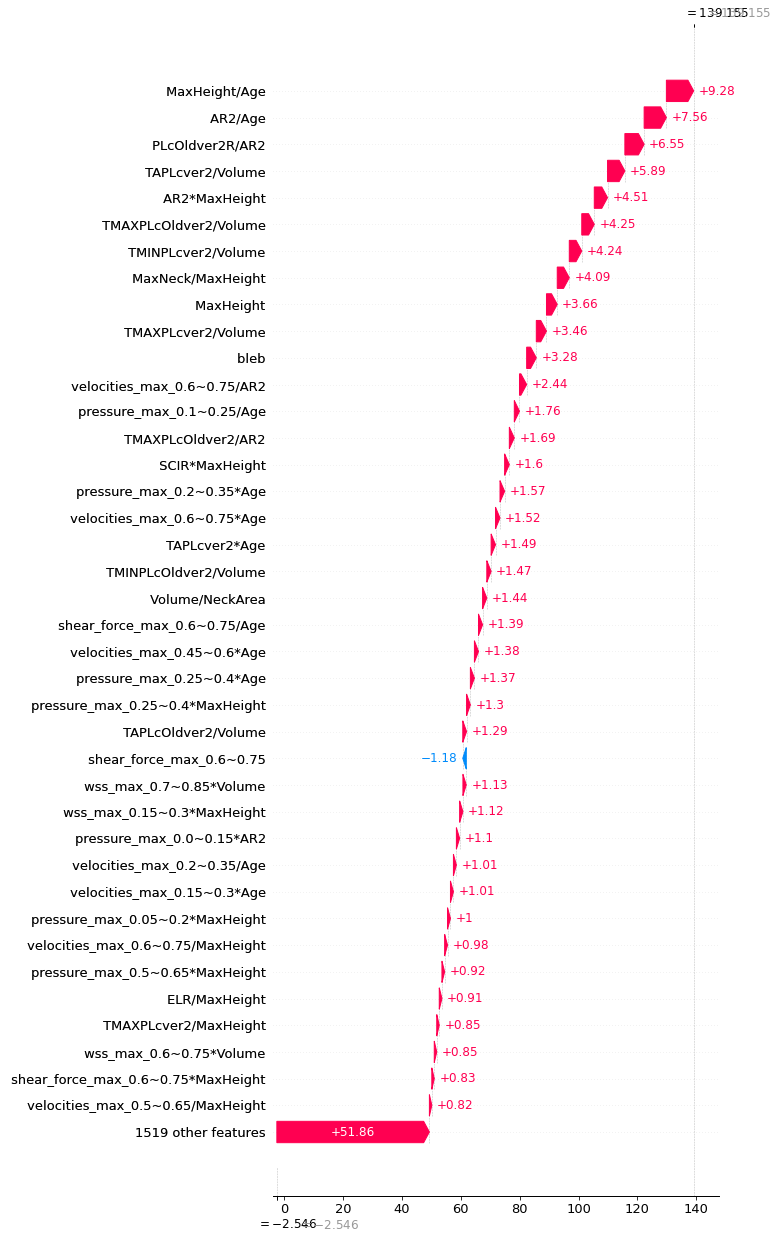

In [69]:
#サンプル番号iの特徴影響度可視化
i = 3
shap.plots._waterfall.waterfall_legacy(np.mean(np.array(expectead_value_li1)[0,:,:,1],),
                    es_total1.loc[x.index[i]].values,
                    x.loc[x.index[i]], max_display = 40)

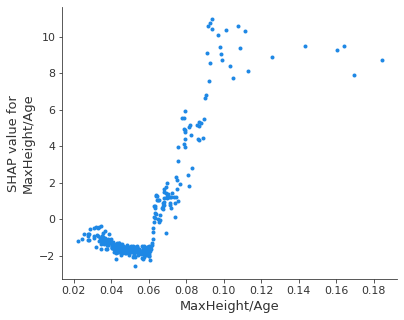

In [43]:
#ある特徴量のSHAP値可視化
z = x.copy()
shap.dependence_plot(ind='MaxHeight/Age',
                     interaction_index=None,
                     shap_values=es_total1.values,
                     features=z.sort_index(),
                     feature_names=z.columns)

In [108]:
#選択した特徴をTexで書く便利ツール
for i in range(20):
    c1 = list(np.sum(abs(es_total1)).sort_values(ascending = False).index[:40])[i]
    c2 = list(np.sum(abs(es_total1)).sort_values(ascending = False).index[:40])[20 + i]
    print(i + 1, "&", list(x.columns)[c1].replace("~", "\\textasciitilde ").replace("_", "\_"), "&", i + 21, "&" ,list(x.columns)[c2].replace("~", "\\textasciitilde ").replace("_", "\_"), "\\\\ \hline")

1 & MaxHeight/Age & 21 & TMAXPLcOldver2/AR2 \\ \hline
2 & pressure\_max\_0.05\textasciitilde 0.2/Age & 22 & pressure\_max\_0.0\textasciitilde 0.15*AR2 \\ \hline
3 & AR2/Age & 23 & MaxHeight \\ \hline
4 & pressure\_max\_0.25\textasciitilde 0.4*Age & 24 & ICIR/AR2 \\ \hline
5 & pressure\_max\_0.2\textasciitilde 0.35*Age & 25 & velocities\_max\_0.6\textasciitilde 0.75*Age \\ \hline
6 & PLcOldver2R/AR2 & 26 & pressure\_max\_0.4\textasciitilde 0.55/Age \\ \hline
7 & AR2*MaxHeight & 27 & SCIR/MaxNeck \\ \hline
8 & pressure\_max\_0.05\textasciitilde 0.2*MaxHeight & 28 & pressure\_max\_0.05\textasciitilde 0.2/AR2 \\ \hline
9 & shear\_force\_max\_0.6\textasciitilde 0.75/Age & 29 & velocities\_max\_0.5\textasciitilde 0.65*MaxNeck \\ \hline
10 & TAPLcver2/Volume & 30 & shear\_force\_max\_0.7\textasciitilde 0.85/Age \\ \hline
11 & TMAXPLcOldver2/Volume & 31 & velocities\_max\_0.15\textasciitilde 0.3*Age \\ \hline
12 & bleb & 32 & Volume/NeckArea \\ \hline
13 & pressure\_max\_0.0\textasciitilde 0.1

In [110]:
for i in range(20):
    c1 = list(np.sum(abs(es_total2)).sort_values(ascending = False).index[:40])[i]
    c2 = list(np.sum(abs(es_total2)).sort_values(ascending = False).index[:40])[20 + i]
    print(i + 1, "&", list(x.columns)[c1].replace("~", "\\textasciitilde ").replace("_", "\_"), "&", i + 21, "&" ,list(x.columns)[c2].replace("~", "\\textasciitilde ").replace("_", "\_"), "\\\\ \hline")

1 & MaxHeight/Age & 21 & velocities\_max\_0.0\textasciitilde 0.15/AR2 \\ \hline
2 & AR2/Age & 22 & TAPLcOldver2/Volume \\ \hline
3 & TMAXPLcOldver2/Volume & 23 & pressure\_max\_0.4\textasciitilde 0.55*MaxHeight \\ \hline
4 & pressure\_max\_0.05\textasciitilde 0.2/Age & 24 & velocities\_max\_0.5\textasciitilde 0.65*MaxNeck \\ \hline
5 & PLcOldver2R/AR2 & 25 & velocities\_max\_0.6\textasciitilde 0.75*MaxNeck \\ \hline
6 & MaxNeck/MaxHeight & 26 & pressure\_max\_0.7\textasciitilde 0.85*Age \\ \hline
7 & TAPLcver2/Volume & 27 & velocities\_max\_0.6\textasciitilde 0.75/MaxHeight \\ \hline
8 & velocities\_max\_0.6\textasciitilde 0.75/AR2 & 28 & pressure\_max\_0.05\textasciitilde 0.2*AR2 \\ \hline
9 & pressure\_max\_0.05\textasciitilde 0.2*MaxHeight & 29 & pressure\_max\_0.55\textasciitilde 0.7*MaxHeight \\ \hline
10 & pressure\_max\_0.25\textasciitilde 0.4*Age & 30 & velocities\_max\_0.6\textasciitilde 0.75*Age \\ \hline
11 & AR2*MaxHeight & 31 & pressure\_max\_0.15\textasciitilde 0.3*MaxHei

In [58]:
#特徴乗除算の効果を出力する便利ツール
fig = go.Figure()
fig.add_trace(go.Scatter(x=[i for i in range(338)], y=(x["Age"] - np.mean(x["Age"]))/(max(x["Age"])-min(x["Age"])), name='Age',line=dict(color = ('rgb(255,20,147)')),mode='markers'))
fig.add_trace(go.Scatter(x=[i for i in range(338)], y=(x["MaxHeight"] - np.mean(x["MaxHeight"]))/(max(x["MaxHeight"])-min(x["MaxHeight"])), name='MaxHeight',line=dict(color = ('rgb(243,152,0)')),mode='markers'))
fig.add_trace(go.Scatter(x=[i for i in range(338)], y=(x["MaxHeight/Age"] - np.mean(x["MaxHeight/Age"]))/(max(x["MaxHeight/Age"])-min(x["MaxHeight/Age"])), name='MaxHeight/Age',line=dict(color = ('rgb(0, 175, 204)')),mode='markers'))
fig.update_layout(height=600, width=1000, title_text='')
fig.update_xaxes(title_text="Sample")
fig.update_yaxes(title_text="Value")
fig.show()